Please note EDA is in a separate file in this same repo.

In [ ]:
!pip install cartopy

In [1]:
import os

# data handling
import re
import xarray   as xr
import numpy    as np
import pandas   as pd

# plotting
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature

# modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import itertools

## Helper Functions

In [2]:
def parse_efth(entry):
    cleaned_entry = re.sub(r'[\[\]\n]', ' ', entry).strip()
    return np.array([float(value) for value in cleaned_entry.split()])

In [3]:
freqs = np.array([0.0373, 0.04103, 0.045133, 0.049646, 0.054611, 0.060072, 0.066079,
                        0.072687, 0.079956, 0.087951, 0.096747, 0.106421, 0.117063, 0.12877,
                        0.141647, 0.155811, 0.171393, 0.188532, 0.207385, 0.228123, 0.250936,
                        0.276029, 0.303632, 0.333996, 0.367395, 0.404135, 0.444548, 0.489003,
                        0.537903, 0.591694, 0.650863, 0.715949])

## Data Preparation

In [4]:
URL = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_2/WWIII-bulk_params%2C1D_spec-fall_2021.csv'

In [5]:
df = pd.read_csv(URL)

### Parse from string to array

The data saved as a string, we need to turn the `spectrum` feature into an array.

In [6]:
df['spectrum'] = df['spectrum'].apply(parse_efth)

### Normalization

Normalization is an important preprocessing step that ensures that no one feature or spectrum is weighted unfairly versus others. There are many ways to normalize; here I will just normalize so the area under the spectrum is equal to 1.

In [7]:
spectra = np.stack(df['spectrum'].values)
spectra_normalized = spectra / spectra.sum(axis=1, keepdims=True)

## Clustering Exploration

I first want to throw my data into a clustering algorithm just to see how it performs. We may not necessarily need to do any crazy feature engineering if the fit is good.

### K-means

K-means is one of the most basic clustering algorithms.

#### Model setup

We'll start with a basic model where I will guess the best number of clusters to be 4. This is based on domain knowledge; I think that the spectra would most likely be grouped into:
1) Narrow-banded swell
2) Developing seas (characterized by wind-waves)
3) Fully developed seas (charaxterized by a "fat" spectrum)
4) Mixed seas (where 2 wave systems have propogated away from their generation site to interact simultaneosly at a given point)

In [8]:
# model initialization
n_clusters = 4 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# fit
kmeans_labels = kmeans.fit_predict(spectra_normalized)

To our origional dataframe, we can add the label for which cluster a spectrum belongs to.

In [9]:
# cluster labels
df['kmeans_label'] = kmeans_labels

#### Model evaluation

Silhouette scores ranges from -1 to 1. The closer to 1 the better. The Calinski-Harabasz Index is a positive number; the larger the better.

In [10]:
silhouette_avg = silhouette_score(spectra_normalized, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(spectra_normalized, kmeans_labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

Silhouette Score: 0.287
Calinski-Harabasz Index: 4356.969


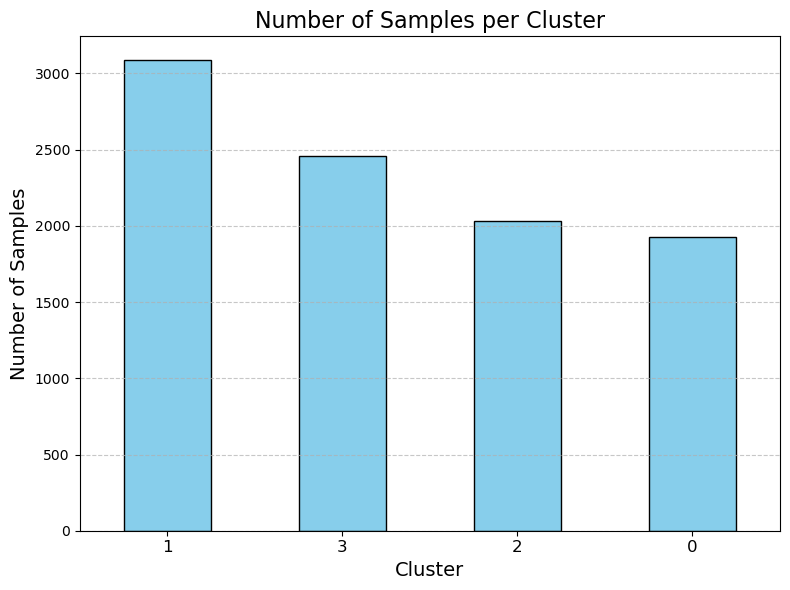

In [11]:
cluster_counts = df['kmeans_label'].value_counts()

pyp.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

pyp.title('Number of Samples per Cluster', fontsize=16)
pyp.xlabel('Cluster', fontsize=14)
pyp.ylabel('Number of Samples', fontsize=14)
pyp.xticks(rotation=0, fontsize=12)
pyp.grid(axis='y', linestyle='--', alpha=0.7)

pyp.tight_layout()
pyp.show()

The clusters are not evenly sized, which makes a lot of sense. Certain types of seas are definately more common than others.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


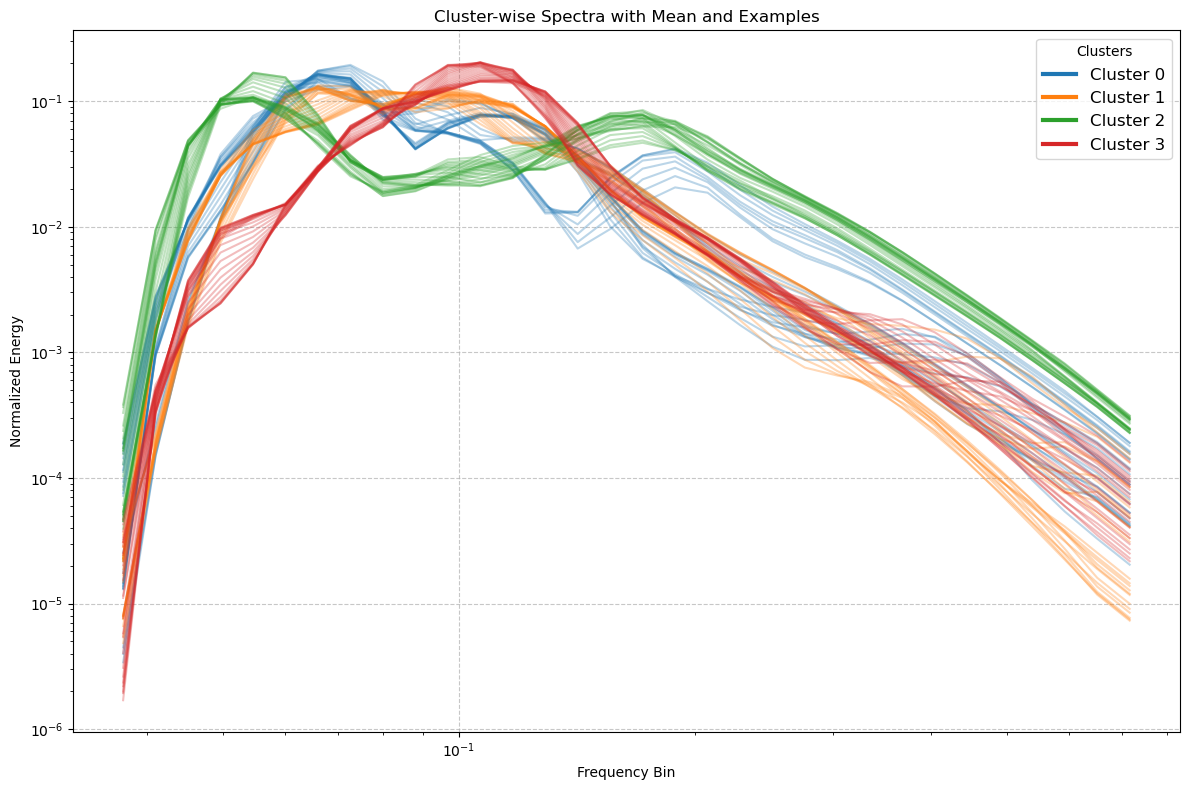

In [ ]:
# define colors for clusters
colors = pyp.cm.tab10(range(n_clusters))

# Initialize the figure
pyp.figure(figsize=(12, 8))

# iterate over each cluster
for cluster in range(n_clusters):
    cluster_samples = spectra_normalized[df['kmeans_label'] == cluster]
    for i in range(min(25, len(cluster_samples))):  # Plot up to 5 examples
        pyp.loglog(freqs, cluster_samples[i], alpha=0.3, color=colors[cluster])

# labels and legends
pyp.title('Cluster-wise Spectra with Mean and Examples')
pyp.xlabel('Frequency Bin')
pyp.ylabel('Normalized Energy')
pyp.legend()
pyp.grid(True, linestyle='--', alpha=0.7)

# legend
handles = [pyp.Line2D([0], [0], color=colors[cluster], lw=3, label=f'Cluster {cluster}') for cluster in range(n_clusters)]
pyp.legend(handles=handles, title='Clusters', loc='upper right', fontsize=12)

# show
pyp.tight_layout()
pyp.show()

This plot shows some examples of spectra in the cluster. The green cluster is definately a grouping of mixed seas. Red seems to be a grouping of developing seas - there is a peak of energy at higher frequencies, but a lack of energy at low frequencies (which take longer to generate). Orange and blue are hard to discern from eachother. However, orange seems to be pretty wide and smooth, which might indicate fully developes seas. Blue does not seem to line up with narrow banded spectra. An exploration of the bulk wave parameters later might help give context to these clusters.

#### Grid search for ideal number of clusters

4 clusters was just a guess. We'll try 2-10 clusters.

In [101]:
cluster_range = range(2, 11)
silhouette_scores = []
ch_scores = []

In [102]:
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(spectra_normalized)
    
    # Calculate metrics
    silhouette_scores.append(silhouette_score(spectra_normalized, cluster_labels))
    ch_scores.append(calinski_harabasz_score(spectra_normalized, cluster_labels))

We can plot the metrics across number of groups.

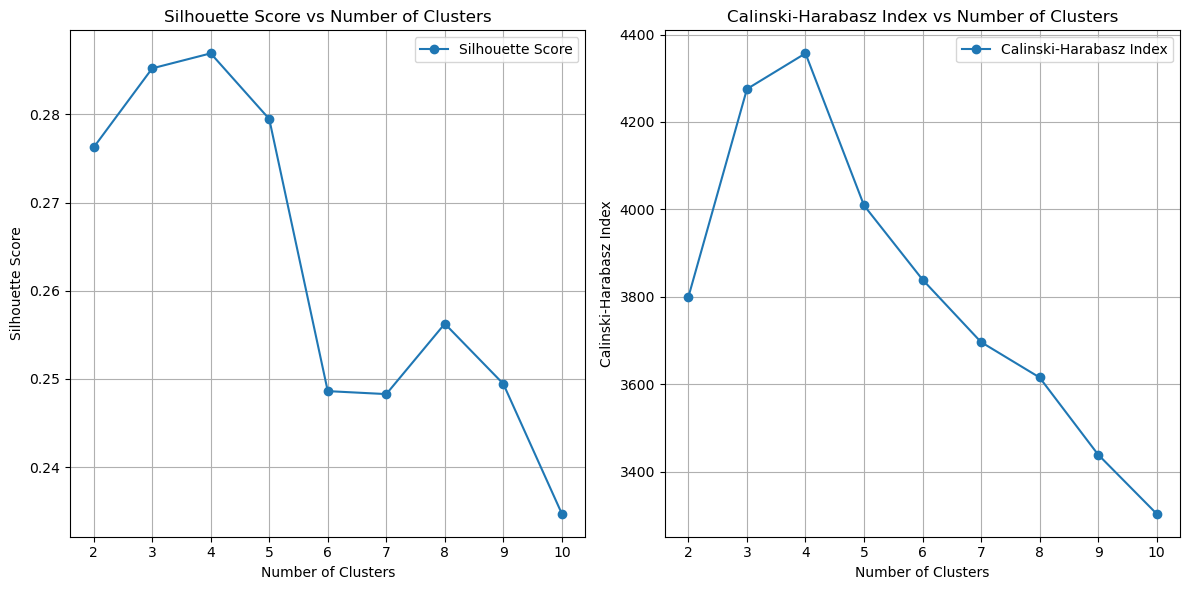

In [103]:
pyp.figure(figsize=(12, 6))

# silhouette score
pyp.subplot(1, 2, 1)
pyp.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
pyp.title('Silhouette Score vs Number of Clusters')
pyp.xlabel('Number of Clusters')
pyp.ylabel('Silhouette Score')
pyp.grid(True)
pyp.legend()

# Calinski-Harabasz index
pyp.subplot(1, 2, 2)
pyp.plot(cluster_range, ch_scores, marker='o', label='Calinski-Harabasz Index')
pyp.title('Calinski-Harabasz Index vs Number of Clusters')
pyp.xlabel('Number of Clusters')
pyp.ylabel('Calinski-Harabasz Index')
pyp.grid(True)
pyp.legend()

pyp.tight_layout()
pyp.show()

As hypothesized, 4 was the ideal number of clusters for both metrics. One interesting point though is that the silhouette score doesn't actually change by much - even at 10 clusters, the score is not much different than when there were 4 groups. I imagine this is becuase there are many spectra that can be placed well in more than one cluster.

### GMM

The Gaussian Mixture Model might provide a better fit beacause it allows for different cluster shapes. Similar to before, we'll start with 4 clusters.

In [104]:
n_clusters = 4  

gmm = GaussianMixture(n_components=n_clusters, covariance_type='tied', random_state=42)
gmm_labels = gmm.fit_predict(spectra_normalized)

df['gmm_label'] = gmm_labels

In [106]:
silhouette_avg = silhouette_score(spectra_normalized, gmm_labels)
calinski_harabasz = calinski_harabasz_score(spectra_normalized, gmm_labels)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

Silhouette Score: 0.257
Calinski-Harabasz Index: 3356.660


This model performed slightly worse than the K-means model, but we haven't tuned it yet!

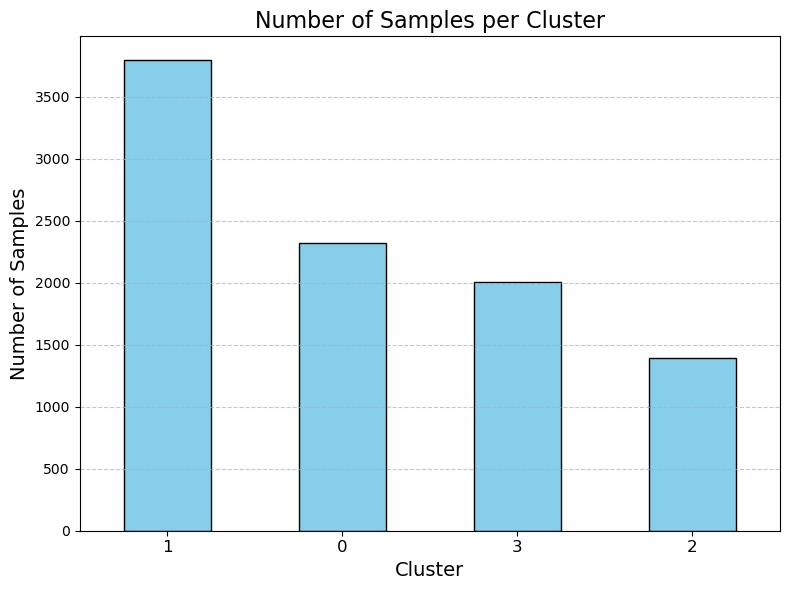

In [105]:
cluster_counts = df['gmm_label'].value_counts()

pyp.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

pyp.title('Number of Samples per Cluster', fontsize=16)
pyp.xlabel('Cluster', fontsize=14)
pyp.ylabel('Number of Samples', fontsize=14)
pyp.xticks(rotation=0, fontsize=12)
pyp.grid(axis='y', linestyle='--', alpha=0.7)

pyp.tight_layout()
pyp.show()

The GMM model definately clustered some spectra differently.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


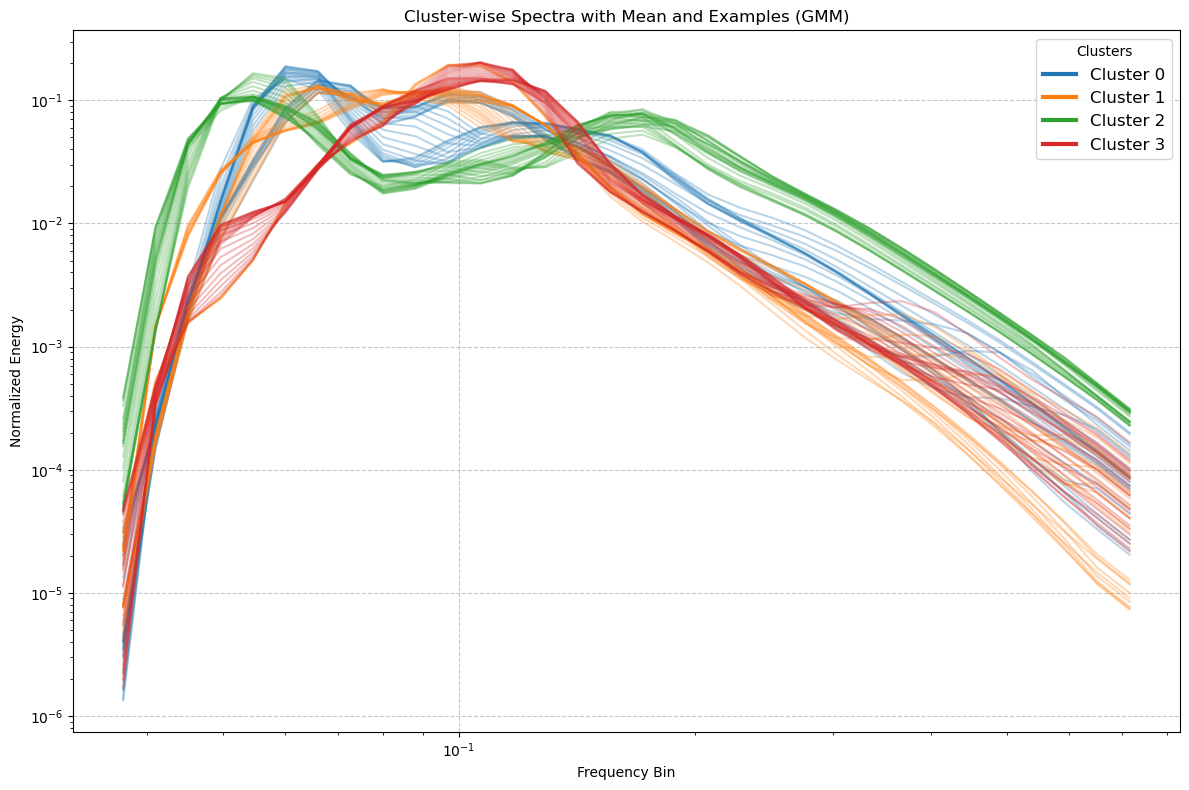

In [108]:
colors = pyp.cm.tab10(range(n_clusters))

pyp.figure(figsize=(12, 8))

for cluster in range(n_clusters):
    cluster_samples = spectra_normalized[df['gmm_label'] == cluster]

    for i in range(min(25, len(cluster_samples))):
        pyp.loglog(freqs, cluster_samples[i], alpha=0.3, color=colors[cluster])

pyp.title('Cluster-wise Spectra with Mean and Examples (GMM)')
pyp.xlabel('Frequency Bin')
pyp.ylabel('Normalized Energy')
pyp.legend()
pyp.grid(True, linestyle='--', alpha=0.7)

# legend
handles = [pyp.Line2D([0], [0], color=colors[cluster], lw=3, label=f'Cluster {cluster}') for cluster in range(n_clusters)]
pyp.legend(handles=handles, title='Clusters', loc='upper right', fontsize=12)

pyp.tight_layout()
pyp.show()

While the GMM model definately put spectra into different clusters, the categories of the spectra seem very similar.

In [110]:
# define parameter grid for hyperparameters
n_components_range = range(2, 11)  # Test from 2 to 10 components
covariance_types = ['full', 'tied', 'diag', 'spherical']

results = []

# generate all combinations of hyperparameters
param_grid = itertools.product(n_components_range, covariance_types)

# grid search
for n_components, covariance_type in param_grid:
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
    
    gmm.fit(spectra_normalized)
    cluster_labels = gmm.predict(spectra_normalized)
    
    silhouette = silhouette_score(spectra_normalized, cluster_labels)
    ch_index = calinski_harabasz_score(spectra_normalized, cluster_labels)
    
    # Store results
    results.append((n_components, covariance_type, silhouette, ch_index))

results_df = pd.DataFrame(results, columns=['n_components', 'covariance_type', 
                                            'silhouette_score', 'calinski_harabasz_index'])

In [111]:
best_model = results_df.sort_values(by='silhouette_score', ascending=False).iloc[0]
best_model

n_components                         4
covariance_type              spherical
silhouette_score              0.267563
calinski_harabasz_index    4174.711258
Name: 11, dtype: object

The best GMM model has 4 clusters and a spherical covariance type. This is essentially the same as the K-means model. It's scores support this as they are basically the same as the K-means model.

## PCA

Since increased model complexity didn't seem to increase our scores, I think now is a good time to try and reduce the dimmensions of my data. First, we need to know how many components is appropriate.

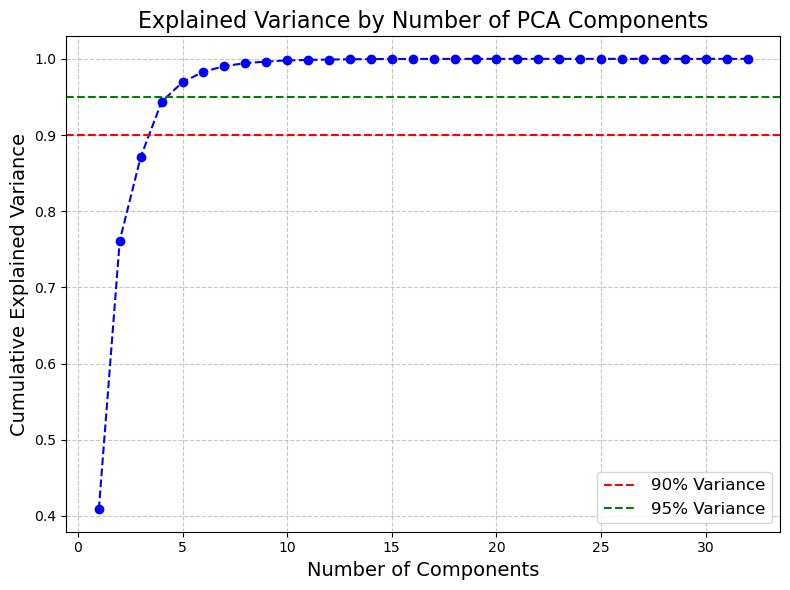

In [112]:
pca = PCA()
pca.fit(spectra_normalized)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

pyp.figure(figsize=(8, 6))
pyp.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
pyp.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
pyp.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')

pyp.title('Explained Variance by Number of PCA Components', fontsize=16)
pyp.xlabel('Number of Components', fontsize=14)
pyp.ylabel('Cumulative Explained Variance', fontsize=14)
pyp.legend(fontsize=12)
pyp.grid(True, linestyle='--', alpha=0.7)
pyp.tight_layout()
pyp.show()

4 components looks like the sweet spot.

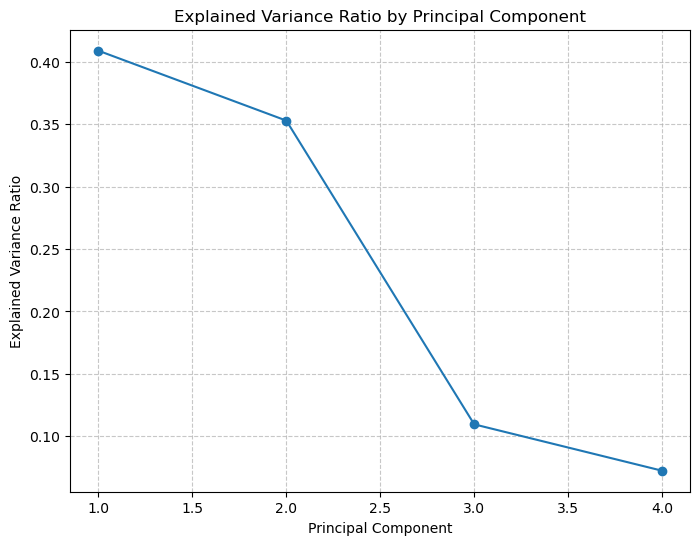

In [113]:
n_components = 4
pca = PCA(n_components=n_components)
spectra_pca = pca.fit_transform(spectra_normalized)

pyp.figure(figsize=(8, 6))
pyp.plot(range(1, n_components + 1), pca.explained_variance_ratio_, marker='o')
pyp.title('Explained Variance Ratio by Principal Component')
pyp.xlabel('Principal Component')
pyp.ylabel('Explained Variance Ratio')
pyp.grid(True, linestyle='--', alpha=0.7)
pyp.show()

### K-means w/ reduced data

In [123]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels_PCA = kmeans.fit_predict(spectra_pca)

In [124]:
df['kmeans_labels_PCA'] = kmeans_labels_PCA

In [125]:
silhouette = silhouette_score(spectra_pca, kmeans_labels_PCA)
calinski_harabasz = calinski_harabasz_score(spectra_pca, kmeans_labels_PCA)

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.3122445096308898
Calinski-Harabasz Index: 5003.873113170832


The reduced data shows some improvement. Again, we will do a grid search just to make sure 4 is still the best number of clusters.

In [117]:
k_values = range(2, 11)
sil_scores = []
calinski_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(spectra_pca)
    
    sil_score = silhouette_score(spectra_pca, kmeans_labels)
    calinski_score = calinski_harabasz_score(spectra_pca, kmeans_labels)
    
    sil_scores.append(sil_score)
    calinski_scores.append(calinski_score)

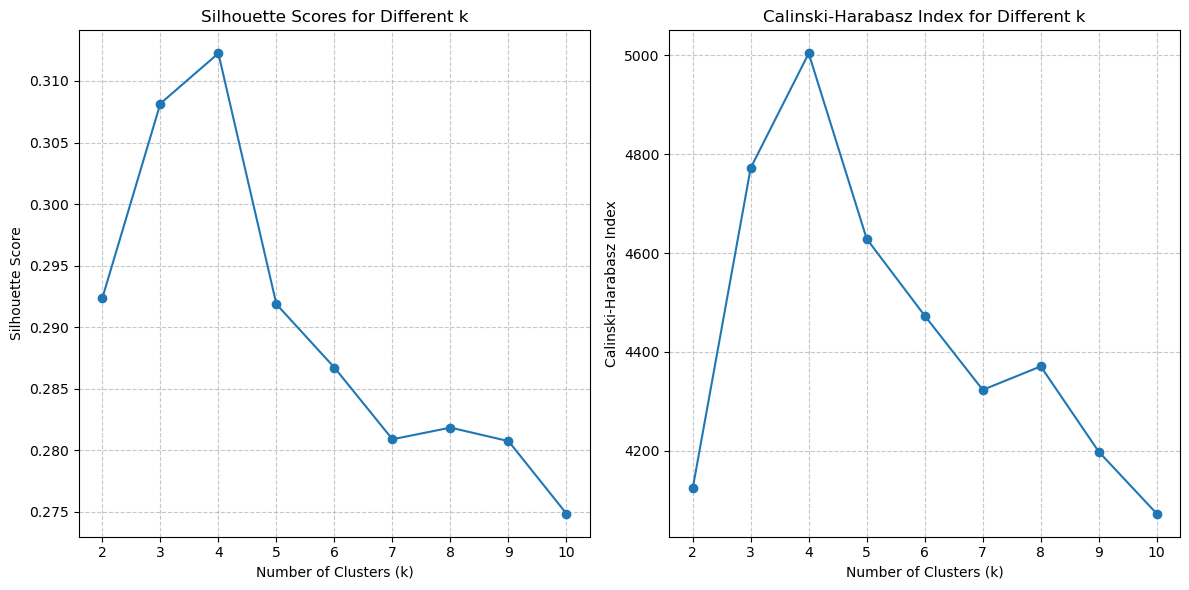

In [120]:
pyp.figure(figsize=(12, 6))

# Plot silhouette scores
pyp.subplot(1, 2, 1)
pyp.plot(k_values, sil_scores, marker='o')
pyp.title('Silhouette Scores for Different k')
pyp.xlabel('Number of Clusters (k)')
pyp.ylabel('Silhouette Score')
pyp.grid(True, linestyle='--', alpha=0.7)

# Plot Calinski-Harabasz index
pyp.subplot(1, 2, 2)
pyp.plot(k_values, calinski_scores, marker='o')
pyp.title('Calinski-Harabasz Index for Different k')
pyp.xlabel('Number of Clusters (k)')
pyp.ylabel('Calinski-Harabasz Index')
pyp.grid(True, linestyle='--', alpha=0.7)

pyp.tight_layout()
pyp.show()

4 is still the best number of clusters.

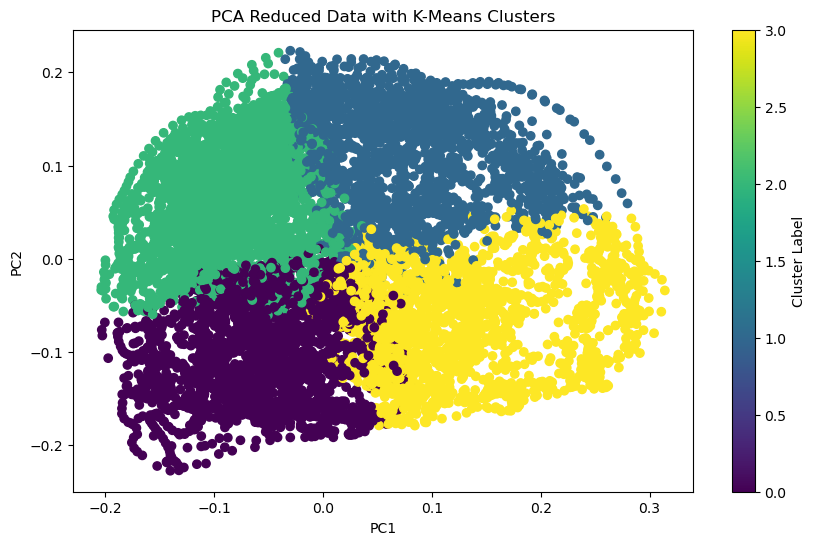

In [126]:
# Step 1: Visualize the reduced PCA space with K-means clustering results
pyp.figure(figsize=(10, 6))
pyp.scatter(spectra_pca[:, 0], spectra_pca[:, 1], c=kmeans_labels_PCA, cmap='viridis')
pyp.title('PCA Reduced Data with K-Means Clusters')
pyp.xlabel('PC1')
pyp.ylabel('PC2')
pyp.colorbar(label='Cluster Label')
pyp.show()

TBH I don't fully understand this plot yet. Will look into it more!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


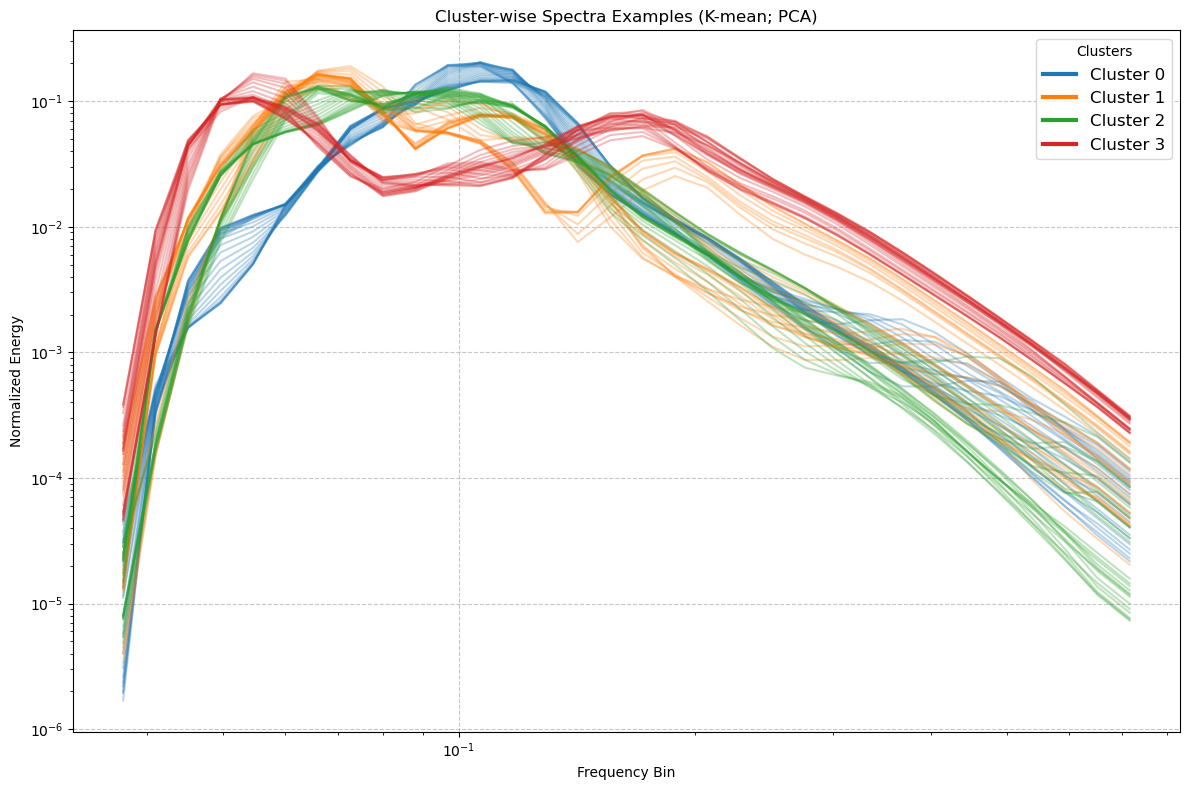

In [127]:
colors = pyp.cm.tab10(range(n_clusters))

pyp.figure(figsize=(12, 8))

for cluster in range(n_clusters):
    cluster_samples = spectra_normalized[df['kmeans_labels_PCA'] == cluster]

    for i in range(min(25, len(cluster_samples))):
        pyp.loglog(freqs, cluster_samples[i], alpha=0.3, color=colors[cluster])

pyp.title('Cluster-wise Spectra Examples (K-mean; PCA)')
pyp.xlabel('Frequency Bin')
pyp.ylabel('Normalized Energy')
pyp.legend()
pyp.grid(True, linestyle='--', alpha=0.7)

# legend
handles = [pyp.Line2D([0], [0], color=colors[cluster], lw=3, label=f'Cluster {cluster}') for cluster in range(n_clusters)]
pyp.legend(handles=handles, title='Clusters', loc='upper right', fontsize=12)

pyp.tight_layout()
pyp.show()

The groups seem a little better defined, but its hard to say without further analysis. The orange group definately has a lot of variety in it. To further investigate this, I'll want to explore the bulk wave parameter space that each group encompasses.

## Short Discussion

### Which method did you like the most?

I liked the K-means algorithm the best because it provided the best scores even though it was less complex than my other models and was not computationally intensive to run.

### Which method did you like the least?

I liked PCA the least. I just don't fully understand it or know of it was the most appropriate way to reduce the dimensionality of this specific type of data.

### How did you score these unsupervised models?  


I used the silhouette score and the Calinski-Harabasz Index. In cases where I performed a grid search to fine the best parameters, I looked at these scores across number of clusters. I also looked at example spectra for each group to use my domain knowledge to assess the clusters that were formed.

### Did the output align with your geologic (oceanographic) understanding?

The two groups that make sense to me are the mixed sea group and the developing sea group (red and blue in the last plot). The other two groups don't seen distinct to be based off of visual inspection. My silhouette scores and Calinski-Harabasz Indices indicate that 3 groups is not appropriate though.

### What did you want to learn more about?

I want to learn more about the parameter space of each cluster and to see if they are distinct. I would do this by making box plots of the most interpretable wave parameters (significant wave height, peak period, peak direction, etc.) across each cluster to see if they span the same range of values or if the each encompass a specific set of values.

### Did you pre-process your data?

I did a lot of preprocessing when I originally developed the data. This included taking the data from the wave model and sorting it into a `dataframe` for only the grid points that I cared about, and merging the datasets that contained the spectral data and bulk wave parameters. Still, for this project, I had to parse the spectral data from a string to an array of numbers, had to normalize it, and applied PCA.

### What was a decision you were most unsure about?

I was unsure about using PCA. To be honest, I don't fully what PCA does, and as mention before, I'm not sure if it's actually an appropriate tool for this data. Using PCA also did not really improve my model scores. I think a better decision would be finding a model that handles high-dimensional data better.